In [149]:
import nengo
import nengo.spa as spa

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [201]:
n_items = 3
t_present = 0.05
D = 16
dt = 0.001

In [151]:
def gen_feed_func(vocab, vocab_items, t_present: float):

    def f(t):
        index = int(t / t_present)
        index = index % len(vocab_items)
        return vocab.parse(vocab_items[index]).v

    return f

In [163]:
vocab = spa.Vocabulary(D)
stim_lbl = ['S1']
targ = np.zeros(n_items)
targ[0] = 1
targ_class = []
targ_class.append(targ)

S1 = vocab.parse('S1')

for i in range(2, n_items+1):
    v = vocab.parse('S1+0.4*R%d' % (i-1))
    v.normalize()
    vocab.add('S%d' % i, v)
    stim_lbl.append('S%d' % i)
    targ = np.zeros(n_items)
    targ[i-1] = 1
    targ_class.append(targ)

stim_vecs = [vocab.parse(ss).v for ss in stim_lbl]

print(np.dot(vocab.parse('S1').v, vocab.parse('S2').v))
print(np.dot(vocab.parse('S1').v, vocab.parse('S3').v))
print(np.dot(vocab.parse('S2').v, vocab.parse('S3').v))

# Baseline

In [202]:
with nengo.Network() as model:
    in_nd = nengo.Node(gen_feed_func(vocab, stim_lbl, t_present))

    recog = nengo.Ensemble(500, D)

    cleanup = nengo.networks.AssociativeMemory(input_vectors=stim_vecs)
    
    nengo.Connection(in_nd, cleanup.input)
    
    p_in = nengo.Probe(in_nd)
    p_out = nengo.Probe(cleanup.output, synapse=0.01)

In [203]:
with nengo.Simulator(model) as sim:
    sim.run(t_present*n_items)

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 


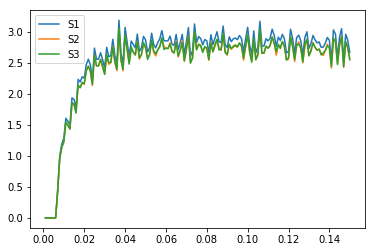

In [204]:
plt.plot(sim.trange(), spa.similarity(sim.data[p_out], stim_vecs))
plt.legend(stim_lbl)

# Decoding directly from oscillator

In [205]:
with nengo.Network() as model:
    in_nd = nengo.Node(gen_feed_func(vocab, stim_lbl, t_present))

    recog = nengo.Ensemble(500, D)

    cleanup = nengo.networks.AssociativeMemory(input_vectors=stim_vecs)
    
    nengo.Connection(in_nd, recog)
    nengo.Connection(recog, cleanup.input)
    nengo.Connection(cleanup.output, recog, transform=-10)
    
    p_in = nengo.Probe(in_nd)
    p_osc = nengo.Probe(recog, synapse=0.01)
    p_spikes = nengo.Probe(recog.neurons, synapse=None)
    p_filt_spikes = nengo.Probe(recog.neurons, synapse=0.01)

In [206]:
with nengo.Simulator(model) as sim:
    sim.run(t_present*n_items)

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 


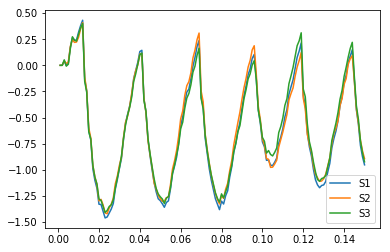

In [207]:
plt.plot(sim.trange(), spa.similarity(sim.data[p_osc], stim_vecs))
plt.legend(stim_lbl)

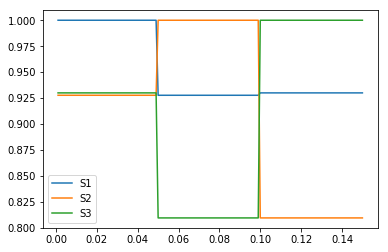

In [208]:
plt.plot(sim.trange(), spa.similarity(sim.data[p_in], stim_vecs))
plt.legend(stim_lbl)

In [210]:
series_len = t_present / dt

repped = []
for targ in targ_class:
    repped.append(np.repeat(targ[None, :], series_len, axis=0))

targ_dat = np.concatenate(repped, axis=0)

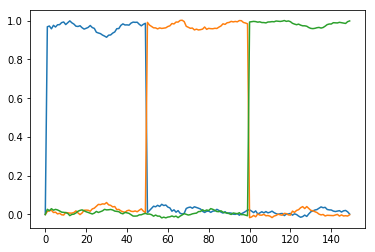

In [211]:
solver = nengo.solvers.LstsqL2(reg=0.02)
decoders, stats = solver(sim.data[p_spikes], targ_dat)
plt.plot(np.dot(sim.data[p_spikes], decoders))

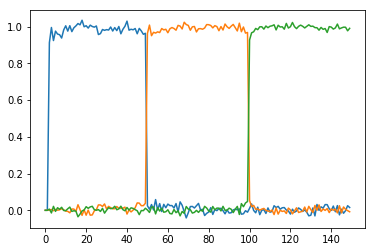

In [212]:
solver = nengo.solvers.LstsqL2(reg=0.02)
decoders, stats = solver(sim.data[p_filt_spikes], targ_dat)
plt.plot(np.dot(sim.data[p_filt_spikes], decoders))

# Decoding from temporal network

Not required due to how effect just decoding from the oscillator is